In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot, format_input_size, report_figsize

In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2021-01-10-report-scaling/*.csv'):
    try:
        benchmark_results.append(pd.read_csv(path))
    except pd.errors.EmptyDataError:
        pass
for path in glob.glob('../../benchmarks/2021-01-11-report-dna/mpi*.csv'):
    try:
        benchmark_results.append(pd.read_csv(path))
    except pd.errors.EmptyDataError:
        pass
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length,input_name
0,0,dna,171309,NaN,NaN,NaN,0,0,mpi_no_master_frontier_simd,1024,120.0,1024,1947629,0,673842,0,99883,streptomyces_aureoverticillatus
4,2,independent,642857,1.0,0.0,zipf,0,4,mpi_priority_frontier,640,120.0,640,107735,0,9699096,0,1124404,NaN
11,2,independent,642857,1.0,0.0,zipf,0,11,mpi_no_master_frontier,896,120.0,896,895694,0,4491814,0,1124404,NaN
33,0,independent,100000,1.0,0.0,zipf,0,6,mpi_priority_frontier_simd,64,120.0,64,20913,0,1631918,0,171132,NaN
100,1,independent,371428,1.0,0.0,zipf,0,40,mpi_no_master_frontier,896,120.0,896,1700964,0,1570936,0,646124,NaN


In [4]:
diff_programs = [
    'mpi_no_master_frontier_simd',
    'mpi_priority_frontier_simd',
]

for diff_program in diff_programs:
    assert (benchmark_results['diff_program'] == diff_program).any()

In [5]:
max_nodes = benchmark_results['mpi_procs'].max() / 128

MPI row-wise


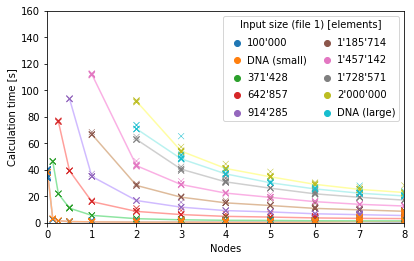

MPI dynamic priority


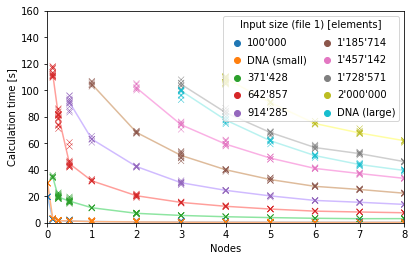

In [6]:
# HACK
def own_hue_to_label(n):
    if n == 171309:
        return "DNA (small)"
    if n == 2696255:
        return "DNA (large)"
    else:
        return format_input_size(n)

#palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
for diff_program_i, diff_program in enumerate(diff_programs):
    fig, ax = plt.subplots(figsize=report_figsize)
    
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['mpi_nodes'] = temp['mpi_procs'] / 128
    temp = temp[(temp['diff_program'] == diff_program) & ((temp['input_strategy'] == 'independent') | (temp['input_strategy'] == 'dna'))]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_nodes'])['seconds_until_len'].median().unstack('input_length_1')
    
    

    plot_scatter_with_lines(
        ax=ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_nodes',
        y_key='seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=own_hue_to_label,
        legend_columns=2,
    )
    ax.set_xticks(np.arange(np.ceil(temp['mpi_nodes'].max()) + 1))
    ax.set_xlim(0, max_nodes)
    ax.set_xticks(np.arange(max_nodes + 1))
    ax.set_ylim(0, 160)
    
    save_plot(fig, f'scaling-time-{nice_name_map[diff_program].replace(" ", "-").lower()}')
    
    # HACK print the title here, but don't save it to the file
    print(nice_name_map[diff_program])
    display(fig)
    plt.close()

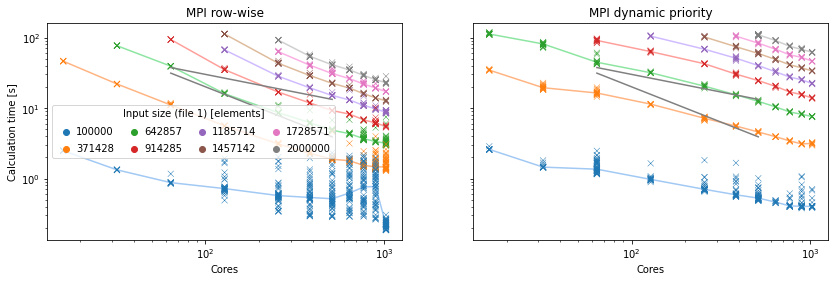

In [7]:
#palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp = temp[temp['mpi_procs'] > 1]
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['seconds_until_len'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_procs',
        y_key='seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
        show_legend=(diff_program_i == 0),
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_xscale('log')
    this_ax.set_yscale('log')
    
    this_ax.plot(np.linspace(64, 512), 2e3 / np.linspace(64, 512), color='grey')
    this_ax.plot(np.linspace(64, 512), 0.3e3 / np.linspace(64, 512) ** 0.5, color='grey')

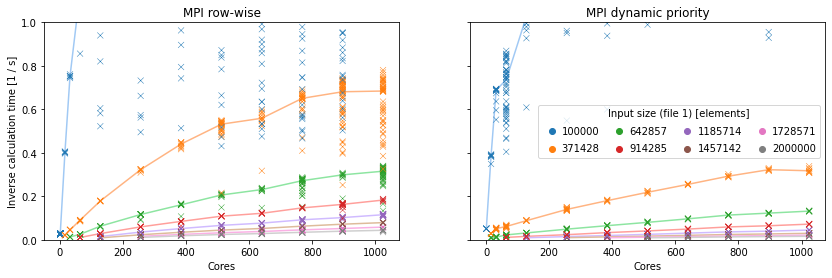

In [8]:
#palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, len(diff_programs), figsize=(14, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(diff_programs):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['inv_seconds_until_len'] = 1 / temp['seconds_until_len']
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['inv_seconds_until_len'].median().unstack('input_length_1')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_procs',
        y_key='inv_seconds_until_len',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=str,
        show_legend=(diff_program_i == 1),
    )
    this_ax.set_title(nice_name_map[diff_program])
    this_ax.set_ylim(0, 1)

In [9]:
temp = benchmark_results.copy()
temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
temp['cells_per_second'] = temp['input_length_1'] * temp['min_edit_length'] / temp['seconds_until_len']
temp['mpi_nodes'] = temp['mpi_procs'] / 128
temp['cost'] = temp['mpi_procs'] * temp['seconds_until_len'] / (temp['input_length_1'] * temp['min_edit_length'])
ideal_cost = temp.loc[temp['mpi_nodes'] >= 1, 'cost'].min()
ideal_cost

2.822258660955577e-09

MPI row-wise


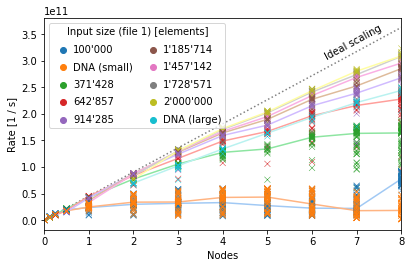

MPI dynamic priority


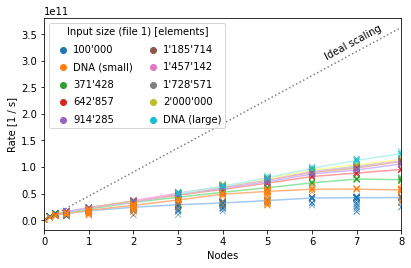

In [10]:
def plot_ideal_scaling_line(ax, ideal_cost):
    ideal_x = np.linspace(0, max_nodes)
    ideal_y = ideal_x * 128 / ideal_cost
    [ideal_line] = ax.plot(
        ideal_x,
        ideal_y,
        color='grey',
        linestyle='dotted',
        zorder=-1,
    )
    
    # HACK must draw first, otherwise ax.transData is wrong
    plt.draw()
    
    ref_pixel_coords = ax.transData.transform([[ideal_x[0], ideal_y[0]], [ideal_x[-1], ideal_y[-1]]])
    ideal_angle_deg = np.rad2deg(np.arctan2(*np.diff(ref_pixel_coords, axis=0).squeeze()[::-1]))
    ideal_label_progress = 0.78
    ideal_label_base_pos = [ideal_label_progress * (ideal_x[-1] - ideal_x[0]) + ideal_x[0], ideal_label_progress * (ideal_y[-1] - ideal_y[0]) + ideal_y[0]]
    ref_label_offset = np.diff(ax.transData.inverted().transform([[0, 10], [0, 0]]), axis=0).squeeze()
    plt.text(
        ideal_label_base_pos[0] - ref_label_offset[0],
        ideal_label_base_pos[1] - ref_label_offset[1],
        'Ideal scaling',
        rotation=ideal_angle_deg,
    )

# palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
for diff_program_i, diff_program in enumerate(diff_programs):
    fig, ax = plt.subplots(figsize=report_figsize)
    
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp['cells_per_second'] = temp['input_length_1'] * temp['min_edit_length'] / temp['seconds_until_len']
    temp['mpi_nodes'] = temp['mpi_procs'] / 128
    temp['cost'] = temp['mpi_procs'] * temp['seconds_until_len'] / (temp['input_length_1'] * temp['min_edit_length'])
    temp = temp[(temp['diff_program'] == diff_program) & ((temp['input_strategy'] == 'independent') | (temp['input_strategy'] == 'dna'))]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_nodes'])['cells_per_second'].median().unstack('input_length_1')
    
    plot_scatter_with_lines(
        ax=ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='mpi_nodes',
        y_key='cells_per_second',
        hue_key='input_length_1',
        sort_hue_keys=True,
        hue_to_label=own_hue_to_label,
        legend_columns=2,
    )
    ax.set_xticks(np.arange(np.ceil(temp['mpi_nodes'].max()) + 1))
    ax.set_xlim(0, max_nodes)
    ax.set_xticks(np.arange(max_nodes + 1))
    
    plot_ideal_scaling_line(ax, ideal_cost)
    
    save_plot(fig, f'scaling-rate-{nice_name_map[diff_program].replace(" ", "-").lower()}')
    
    # HACK print the title here, but don't save it to the file
    print(nice_name_map[diff_program])
    display(fig)
    plt.close()

In [11]:
temp = benchmark_results.copy()
temp = temp[temp['input_strategy'] == 'dna']
temp['min_edit_length'].unique()

array([  99883, 1834756])